In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alessiocorrado99_animals10_path = kagglehub.dataset_download('alessiocorrado99/animals10')

print('Data source import complete.')

Data source import complete.


# Proyek Klasifikasi Gambar: Animals-10
- **Nama:** Nurrizky Arum Jatmiko
- **Email:** nurrizkyaj.core@gmail.com
- **ID Dicoding:** nurrizkyarumjatmiko

## Import Semua Packages/Library yang Digunakan

In [2]:
# Install libraries
!pip install packaging==23.2
!pip install tensorflowjs

In [3]:
# Import libraries
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import tensorflowjs as tfjs

from sklearn.model_selection import train_test_split

from google.colab import files
from IPython.display import Image as IPyImage, display

## Data Preparation

### Data Loading

In [4]:
# Load the dataset
dir_dataset = '/kaggle/input/animals10/raw-img/'
categories = ['mucca', 'elefante', 'cavallo']
valid_ext = ['.jpg', '.jpeg', '.png']

In [5]:
# Check amount of images
all_images = glob.glob(os.path.join(dir_dataset, '*', '*.*'))
filtered_images = [
    img for img in all_images
    if os.path.basename(os.path.dirname(img)) in categories and os.path.splitext(img)[1].lower() in valid_ext
]

def count_images(directory, categories):
    print("Total images in all categories\t\t:", len(all_images))
    print("Total images in selected categories\t:", len(filtered_images))

    total_images = 0
    for category in categories:
        path = os.path.join(directory, category)
        files = [
            f for f in os.listdir(path)
            if os.path.splitext(f)[1].lower() in valid_ext
        ]
        count = len(files)
        print(f"Total {category} images \t\t\t: {count}")
        total_images += count
    return

count_images(dir_dataset, categories)

Total images in all categories		: 26179
Total images in selected categories	: 5935
Total mucca images 			: 1866
Total elefante images 			: 1446
Total cavallo images 			: 2623


In [6]:
# Check resolutions of images
def print_image_resolutions(directory, categories):
    for category in categories:
        path = os.path.join(directory, category)
        files = [
            f for f in os.listdir(path)
            if os.path.splitext(f)[1].lower() in valid_ext
        ]
        print(f"{category} resolutions\t:")
        sizes = set()
        for f in files:
            try:
                with Image.open(os.path.join(path, f)) as img:
                    sizes.add(img.size)
            except Exception as e:
                print(f"- Error reading {f}: {e}")
        for size in sizes:
            print(f"- {size}")

print_image_resolutions(dir_dataset, categories)

mucca resolutions	:
- (300, 206)
- (300, 151)
- (300, 270)
- (221, 300)
- (300, 215)
- (232, 300)
- (300, 279)
- (199, 132)
- (296, 211)
- (282, 221)
- (300, 236)
- (288, 216)
- (240, 160)
- (300, 300)
- (272, 229)
- (300, 245)
- (234, 300)
- (300, 190)
- (300, 181)
- (300, 135)
- (300, 254)
- (273, 300)
- (300, 199)
- (238, 300)
- (300, 144)
- (300, 263)
- (300, 208)
- (286, 218)
- (276, 183)
- (251, 300)
- (270, 194)
- (300, 110)
- (300, 229)
- (300, 165)
- (300, 174)
- (259, 194)
- (300, 119)
- (200, 300)
- (211, 300)
- (300, 183)
- (222, 300)
- (300, 247)
- (300, 192)
- (300, 256)
- (150, 180)
- (300, 201)
- (272, 194)
- (213, 300)
- (292, 300)
- (120, 90)
- (239, 300)
- (300, 231)
- (300, 176)
- (300, 295)
- (300, 240)
- (300, 185)
- (300, 130)
- (300, 249)
- (300, 194)
- (230, 172)
- (300, 258)
- (300, 203)
- (300, 267)
- (230, 300)
- (241, 300)
- (213, 293)
- (250, 202)
- (180, 180)
- (300, 224)
- (300, 169)
- (300, 288)
- (300, 114)
- (300, 233)
- (300, 178)
- (300, 242)
- (300

### Data Preprocessing

#### Split Dataset

In [7]:
# Filter only selected categories and split the dataset
labels = [os.path.basename(os.path.dirname(path)) for path in filtered_images]
df = pd.DataFrame({'filename': filtered_images, 'label': labels})

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 4748, Val: 593, Test: 594


In [8]:
# Create data generators with preprocessing and optional shuffling
img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_generator(dataframe, shuffle, name):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle,
        name=name
    )

train_gen = create_generator(train_df, shuffle=True, name='train')
val_gen = create_generator(val_df, shuffle=False, name='val')
test_gen = create_generator(test_df, shuffle=False, name='test')

Found 4748 validated image filenames belonging to 3 classes.
Found 593 validated image filenames belonging to 3 classes.
Found 594 validated image filenames belonging to 3 classes.


## Modelling

In [9]:
# Build model using transfer learning with MobileNetV2
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(df['label'].unique()), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,653,859 (10.12 MB)

 Trainable params: 395,875 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Check accuracy and val_accuracy
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc and val_acc and acc > 0.96 and val_acc > 0.96:
            print("\nAccuracy and val_accuracy > 96%. Training stopped.")
            self.model.stop_training = True

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    AccuracyThresholdCallback()
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.8599 - loss: 0.3718 - val_accuracy: 0.9578 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9625 - loss: 0.1080
Accuracy and val_accuracy > 96%. Training stopped.
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9625 - loss: 0.1081 - val_accuracy: 0.9646 - val_loss: 0.1140 - learning_rate: 0.0010


## Evaluasi dan Visualisasi

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.9599 - loss: 0.1001


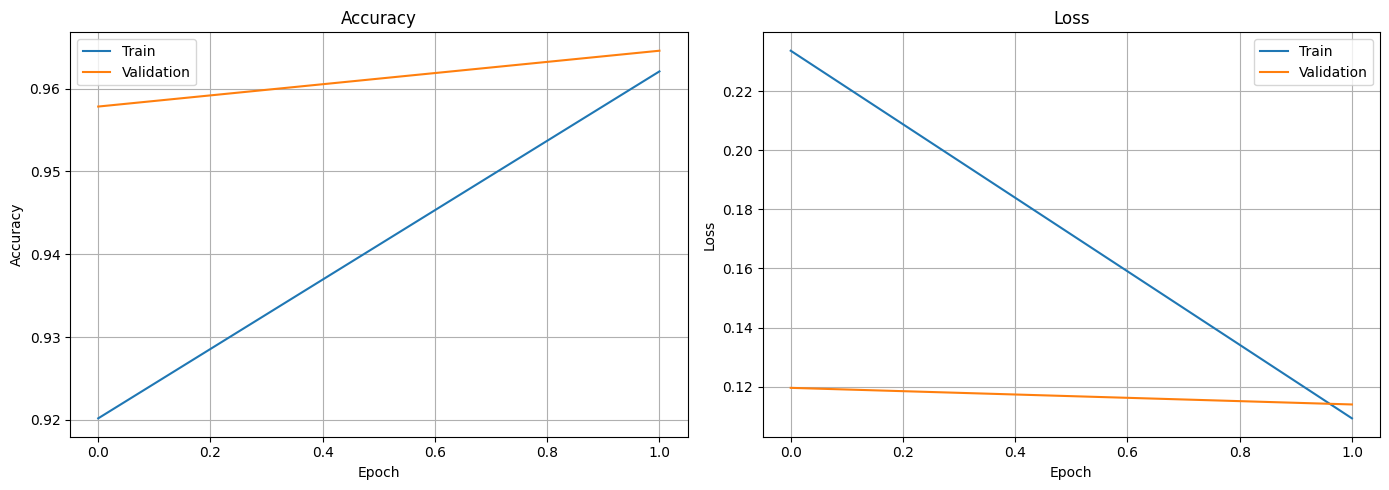

In [12]:
# Plot training & validation accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Konversi Model

In [13]:
# Save the model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137812646316368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646323088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646316752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646316944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646324624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646324816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646324240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646321552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646325008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646314064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137812646325392

In [14]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [15]:
# Save the labels
class_labels = list(train_gen.class_indices.keys())
with open('tflite/label.txt', 'w') as f:
    for label in class_labels:
        f.write(label + '\n')

In [16]:
# Convert the model to TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

Saving elefante.jpg to elefante.jpg


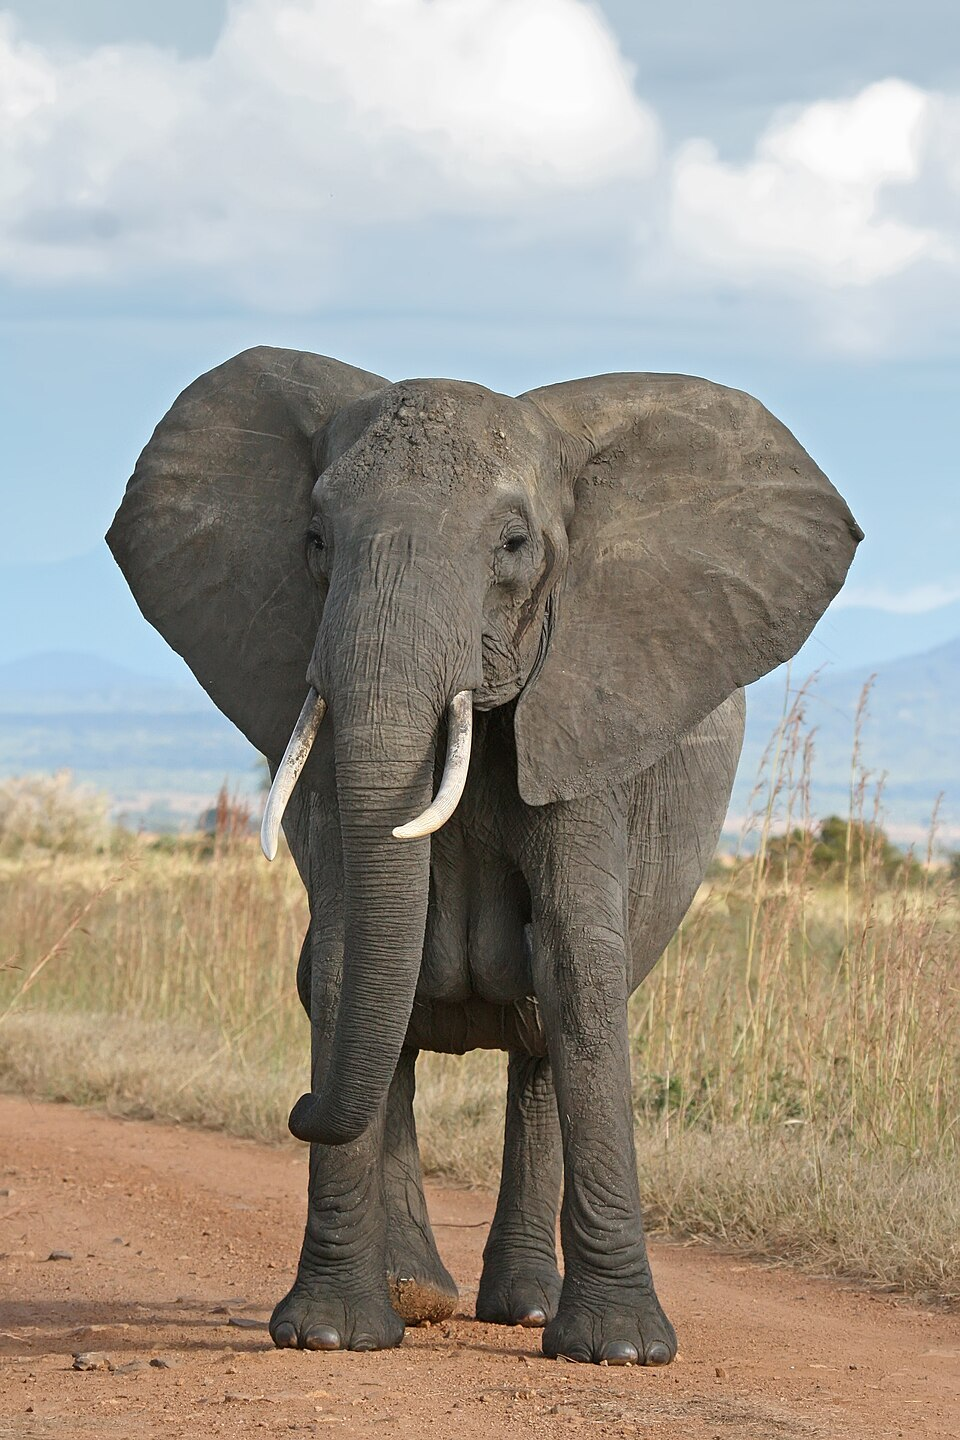

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted label: elefante (Confidence: 1.00)


In [17]:
# Inference
def upload_and_predict_colab():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img_path = fn
        img = image.load_img(img_path, target_size=(224, 224))

        display(IPyImage(filename=img_path))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        class_indices = train_gen.class_indices
        labels = [None]*len(class_indices)
        for label, idx in class_indices.items():
            labels[idx] = label

        predicted_class_idx = np.argmax(preds[0])
        predicted_label = labels[predicted_class_idx]
        confidence = preds[0][predicted_class_idx]

        print(f"Predicted label: {predicted_label} (Confidence: {confidence:.2f})")

upload_and_predict_colab()

## Requirements

In [18]:
!pip freeze > requirements.txt